In [7]:
from imports import *
from agents import BetaAgent
from model import Model
from network_utils import *
from network_randomization import *
from network_generation import *
from simulation_functions import *

# Testing Generated

In [ ]:
n_simulations = 10
G_default = barabasi_albert_directed(200,5)

num_cores = cpu_count()  # Get the number of available CPU cores
print(num_cores)

# Define a partial function to pass G_perceptron to generate_parameters_empir
# This ensures that generate_parameters_empir is called with the correct argument within the pool
# The 'partial' function allows you to create a new function with some of the arguments pre-filled.
from functools import partial
generate_params_with_G = partial(generate_parameters, G=G_default)

with Pool(num_cores) as pool:
    # Use tqdm to display a progress bar
    # Now, 'generate_params_with_G' is the function that will be executed by each worker.
    # Each worker will receive an index from 'range(n_simulations)' as its argument,
    # which is ignored in 'generate_params_with_G' but is required by the 'imap_unordered' function.
    param_dict = list(tqdm.tqdm(pool.imap_unordered(generate_params_with_G, range(n_simulations)), total=n_simulations))

8


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(len(param_dict))
param_dict[0]

10


{'randomized': True,
 'unique_id': '3383e7ecf2184ad2916b5783ac760d94',
 'n_agents': 200,
 'network': <networkx.classes.digraph.DiGraph at 0x110fbf490>,
 'uncertainty': 0.0004620976636038947,
 'n_experiments': 4501,
 'p_rewiring': 0.4650104072331376,
 'average_degree': 4.925,
 'degree_gini_coefficient': np.float64(0.5482994923857868),
 'approx_average_clustering_coefficient': 0.061007621972433396,
 'avg_path_length': 201,
 'degree_entropy': np.float64(2.2960389697381656),
 'reachability_dominator_set_size': 1,
 'reachability_dominator_set_ratio': 0.005,
 'condensation_graph_size': 14,
 'condensation_graph_ratio': 0.07}

In [ ]:
# Run simulations in parallel
with Pool(num_cores) as pool:
    simulation_results = list(tqdm.tqdm(pool.imap_unordered(run_simulation_with_params, param_dict),
                                        total=len(param_dict), desc="Running simulations"))

# Convert results to a DataFrame
basic_results_df = pd.DataFrame(simulation_results)
display(basic_results_df)

Running simulations: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


,randomized,unique_id,n_agents,uncertainty,n_experiments,p_rewiring,average_degree,degree_gini_coefficient,approx_average_clustering_coefficient,avg_path_length,degree_entropy,reachability_dominator_set_size,reachability_dominator_set_ratio,condensation_graph_size,condensation_graph_ratio,share_of_correct_agents_at_convergence,convergence_step,init_agents_alphas_betas,degree_centrality_vector,simulation_seed
0,True,de2fe1e79d9d47e9aaed887b3cc8050e,200,0.000669,9048,0.409167,4.925,0.603152,0.074644,201,2.326075,1,0.005,27,0.135,0.740,3,here goes the list of initial alphas and betas,here goes the degree centrality vector,2211234829
1,True,2e0df24b2ab64c6bb1fa26209b8e7590,200,0.000418,8537,0.079846,4.925,0.800431,0.143447,201,2.088301,1,0.005,133,0.665,0.530,3,here goes the list of initial alphas and betas,here goes the degree centrality vector,2458528638
2,True,343bbd399451411a82a592dbc9679fa2,200,0.000302,5072,0.222302,4.925,0.725355,0.116983,201,2.186511,1,0.005,67,0.335,0.790,4,here goes the list of initial alphas and betas,here goes the degree centrality vector,3475169398
3,True,3383e7ecf2184ad2916b5783ac760d94,200,0.000462,4501,0.465010,4.925,0.548299,0.061008,201,2.296039,1,0.005,14,0.070,0.645,4,here goes the list of initial alphas and betas,here goes the degree centrality vector,3011824585
4,True,c0c4befb3725425f8ea7d367999bda88,200,0.000058,2859,0.192996,4.925,0.728340,0.115279,201,2.211166,1,0.005,59,0.295,0.355,5,here goes the list of initial alphas and betas,here goes the degree centrality vector,3143792422
5,True,19a304344e7546cd86a081e64be78ccb,200,0.000655,4142,0.391359,4.925,0.606178,0.071532,201,2.321841,1,0.005,23,0.115,0.345,5,here goes the list of initial alphas and betas,here goes the degree centrality vector,3467840976
6,True,b00c568b1b164c05beea72bb3285bb54,200,0.000867,3104,0.706422,4.925,0.418838,0.033224,201,2.385633,1,0.005,9,0.045,0.610,7,here goes the list of initial alphas and betas,here goes the degree centrality vector,1298040200
7,True,9402eb0314ab4c078db3c3c9b0803b90,200,0.000717,4248,0.524966,4.925,0.500756,0.052398,201,2.326623,1,0.005,10,0.050,0.420,3,here goes the list of initial alphas and betas,here goes the degree centrality vector,4020044741
8,True,4ecbe7bed9a0493eb7f525d76cea6bb0,200,0.000613,1647,0.931322,4.925,0.258127,0.023279,201,2.189511,1,0.005,3,0.015,0.665,7,here goes the list of initial alphas and betas,here goes the degree centrality vector,1287758095
9,True,996b7f38956840c3ab3e948e8dfa9a3d,200,0.000913,4700,0.525315,4.925,0.541234,0.053840,201,2.343783,1,0.005,14,0.070,0.450,6,here goes the list of initial alphas and betas,here goes the degree centrality vector,635371483


In [ ]:
basic_results_df.to_csv("basic_results_df.csv", index=False)  # Saves without index
scatter_plot(basic_results_df)
scatter_plot(basic_results_df, target_variable="convergence_step")

KeyboardInterrupt: 

# Testing Empirical

In [ ]:
with open('./empirical_networks/perc_pruned_lcc.pkl', 'rb') as f:
  G_perceptron = pickle.load(f)

n_agents = G_perceptron.number_of_nodes()
print(n_agents)

# Create a mapping from node names to indexes
mapping = {node: index for index, node in enumerate(G_perceptron.nodes())}

# Relabel the nodes in the graph
G_perceptron_indexed = nx.relabel_nodes(G_perceptron, mapping)
G_default = G_perceptron_indexed


n_simulations = 10

num_cores = cpu_count()  # Get the number of available CPU cores
print(num_cores)

# Define a partial function to pass G_perceptron to generate_parameters_empir
# This ensures that generate_parameters_empir is called with the correct argument within the pool
# The 'partial' function allows you to create a new function with some of the arguments pre-filled.
from functools import partial
generate_params_with_G = partial(generate_parameters, G=G_default)

with Pool(num_cores) as pool:
    # Use tqdm to display a progress bar
    # Now, 'generate_params_with_G' is the function that will be executed by each worker.
    # Each worker will receive an index from 'range(n_simulations)' as its argument,
    # which is ignored in 'generate_params_with_G' but is required by the 'imap_unordered' function.
    param_dict = list(tqdm.tqdm(pool.imap_unordered(generate_params_with_G, range(n_simulations)), total=n_simulations))
    
param_dict[0]

138
8


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


{'randomized': True,
 'unique_id': '03c8b7d43bdb4a9bb85cfc18e4cb2d5a',
 'n_agents': 138,
 'network': <networkx.classes.digraph.DiGraph at 0x1153793c0>,
 'uncertainty': 0.0018502696849356107,
 'n_experiments': 5,
 'p_rewiring': 0.38704612756763135,
 'average_degree': 2.152173913043478,
 'degree_gini_coefficient': np.float64(0.5938857170741229),
 'approx_average_clustering_coefficient': 0.057758222808479934,
 'diameter': 139,
 'avg_path_length': 139,
 'degree_entropy': np.float64(1.8148165974965935)}

Running simulations: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


,randomized,unique_id,n_agents,uncertainty,n_experiments,p_rewiring,average_degree,degree_gini_coefficient,approx_average_clustering_coefficient,diameter,avg_path_length,degree_entropy,share_of_correct_agents_at_convergence,convergence_step,init_agents_alphas_betas,degree_centrality_vector
0,True,f490ec72673747e982ed81fcd8c0ef14,138,0.000839,12,0.115590,2.152174,0.737154,0.095517,139,139,1.716684,0.456522,29,"[[[1.1746392588850014, 2.21822319400447], [179...","[0.029197080291970802, 0.0072992700729927005, ..."
1,True,87ab2500dfc5436aac3c53cc14ab910a,138,0.001796,10,0.122246,2.152174,0.751452,0.094753,139,139,1.715342,0.405797,33,"[[[1.2679027804922467, 2.0958188546140617], [1...","[0.021897810218978103, 0.014598540145985401, 0..."
2,True,eb7e670714934cdc8bd080ef796cec7f,138,0.002342,13,0.481790,2.152174,0.545674,0.034517,139,139,1.765758,0.644928,38,"[[[430.5417392615859, 467.8641083702038], [41....","[0.021897810218978103, 0.029197080291970802, 0..."
3,True,52812d4c95b44c20ba77a5d9aa822333,138,0.001637,12,0.398625,2.152174,0.600327,0.024378,139,139,1.791166,0.456522,39,"[[[337.59943125057305, 411.4980283925798], [97...","[0.029197080291970802, 0.0072992700729927005, ..."
4,True,90eccdf9900e46efb8413f44fb2fff98,138,0.002084,9,0.662277,2.152174,0.473698,0.019183,139,139,1.750646,0.528986,49,"[[[221.48691327277282, 226.7791040123334], [0....","[0.043795620437956206, 0.014598540145985401, 0..."
5,True,03c8b7d43bdb4a9bb85cfc18e4cb2d5a,138,0.001850,5,0.387046,2.152174,0.593886,0.057758,139,139,1.814817,0.521739,49,"[[[220.46824807795753, 261.9784171307519], [2....","[0.029197080291970802, 0.014598540145985401, 0..."
6,True,6ad8da582ec84fc9aca385d416fc13b8,138,0.001738,2,0.049710,2.152174,0.776924,0.090726,139,139,1.644149,0.434783,51,"[[[0.09553586034487038, 1.7585332393089002], [...","[0.021897810218978103, 0.0072992700729927005, ..."
7,True,ce666eaef4594c8299250efbb5967cbd,138,0.000737,5,0.798309,2.152174,0.420558,0.019553,139,139,1.732475,0.673913,53,"[[[74.30800184668189, 87.92768893140543], [442...","[0.043795620437956206, 0.0364963503649635, 0.0..."
8,True,b47cde34aecf46e2a8939db9bd410cf5,138,0.001871,15,0.934635,2.152174,0.380984,0.011367,139,139,1.754057,0.565217,33,"[[[172.97839134638653, 160.89346313022614], [3...","[0.014598540145985401, 0.029197080291970802, 0..."
9,True,04a8c17a836a486abd5e5172527eabdc,138,0.001110,10,0.130365,2.152174,0.736373,0.068745,139,139,1.734002,0.565217,32,"[[[0.20872239600029285, 1.475320439294308], [1...","[0.021897810218978103, 0.0072992700729927005, ..."


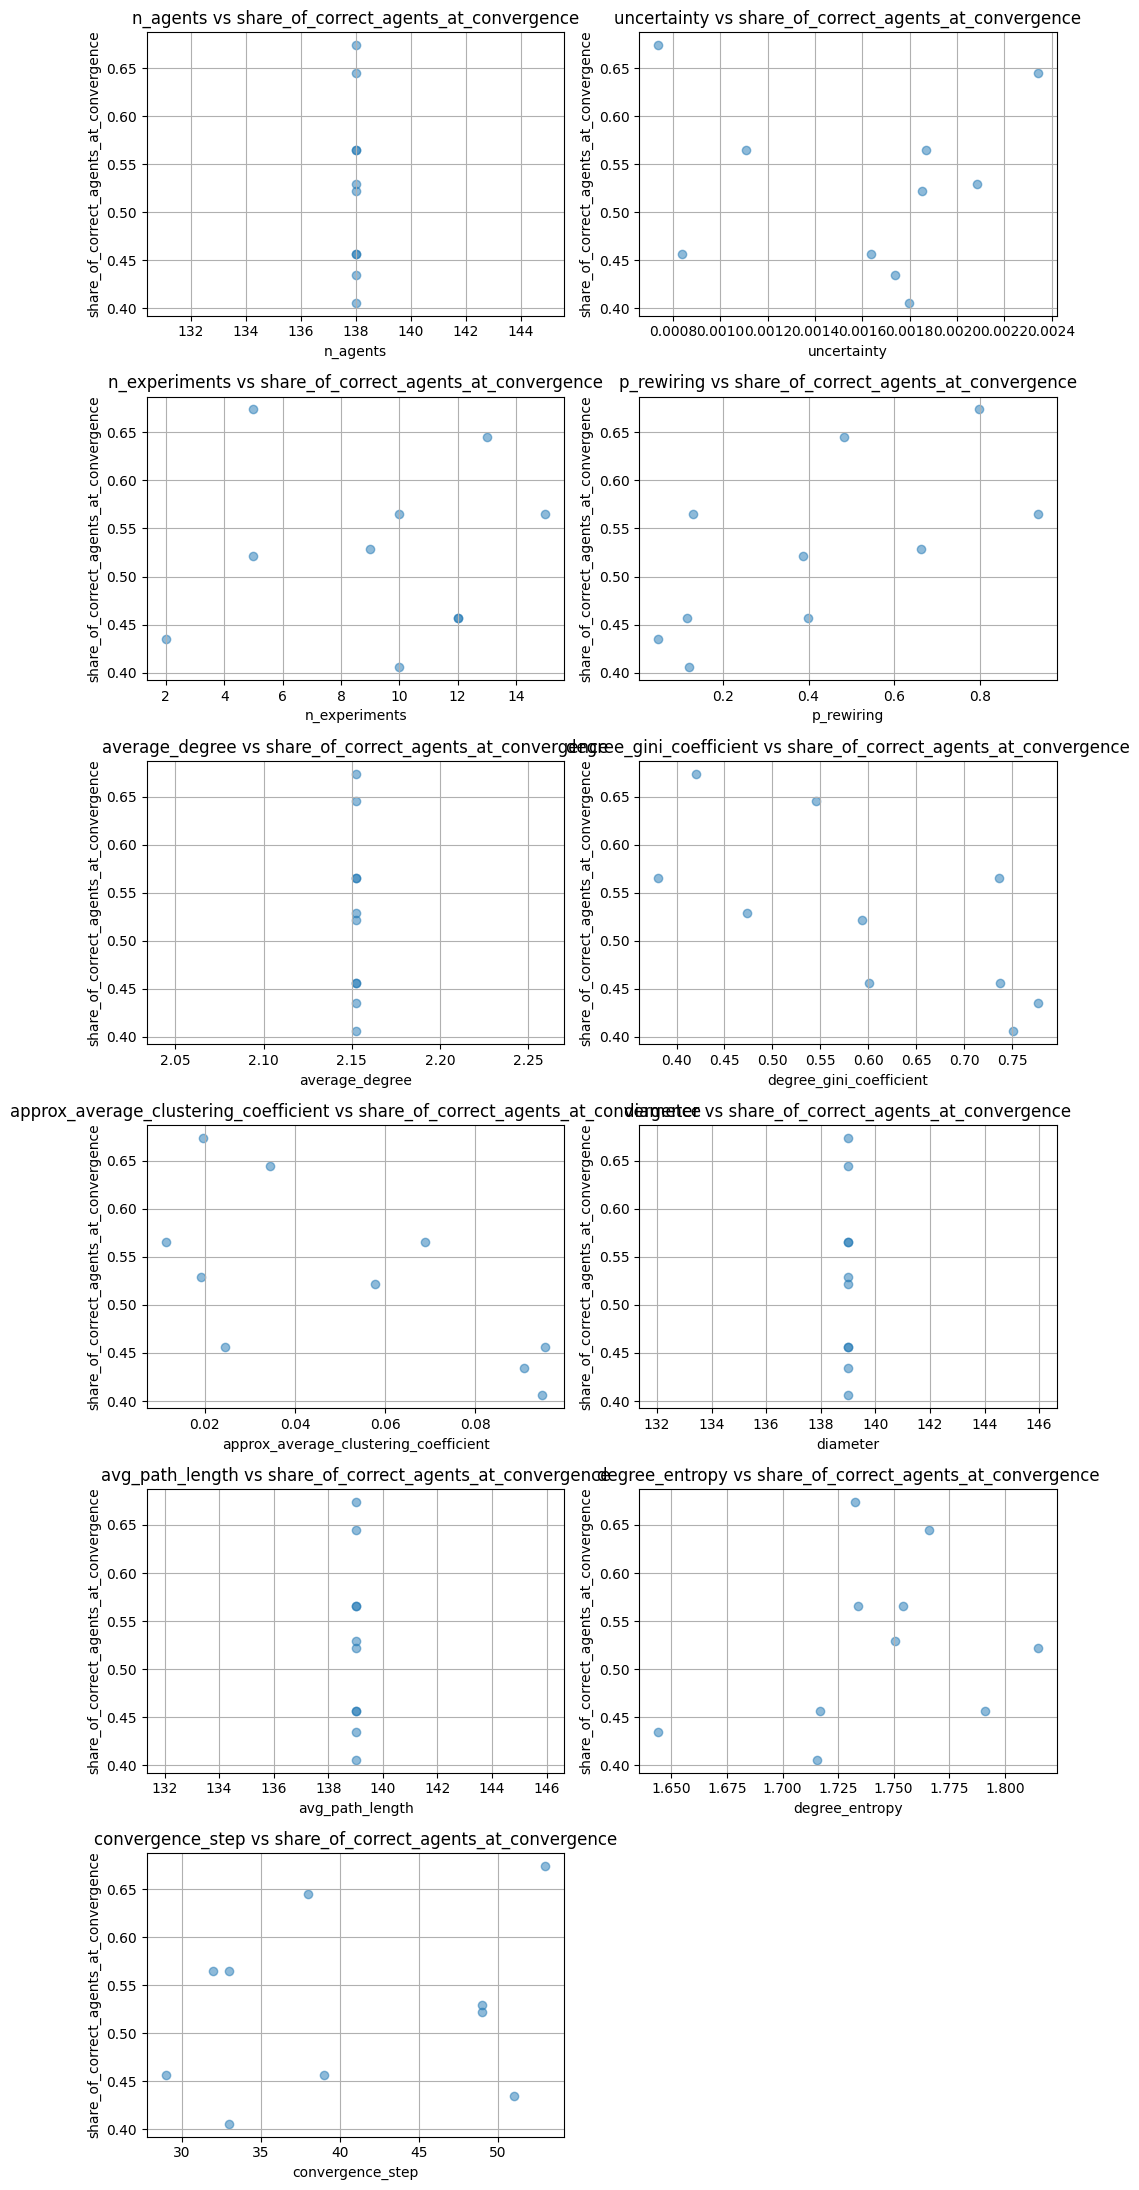

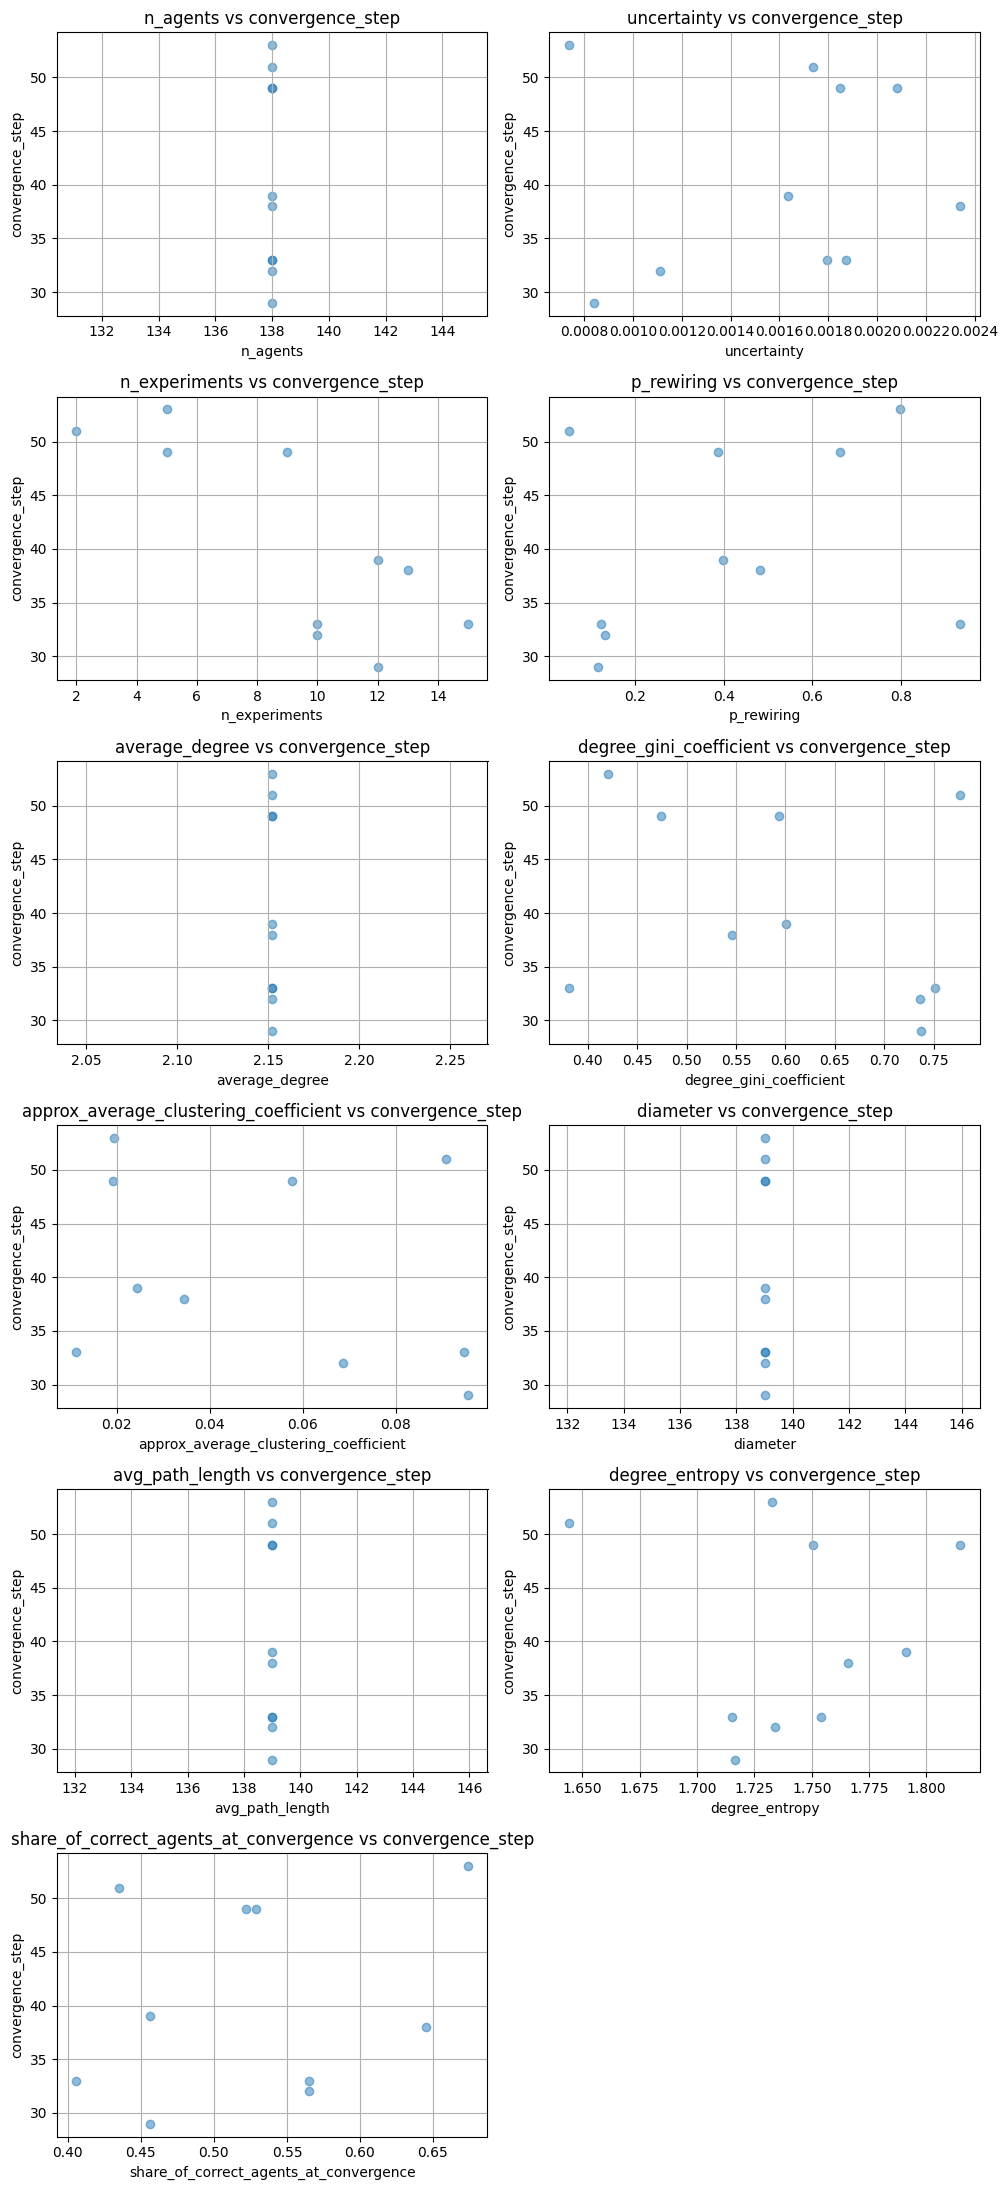

In [ ]:
# Run simulations in parallel
with Pool(num_cores) as pool:
    simulation_results = list(tqdm.tqdm(pool.imap_unordered(run_simulation_wrapper, param_dict),
                                        total=len(param_dict), desc="Running simulations"))

# Convert results to a DataFrame
basic_results_df = pd.DataFrame(simulation_results)
display(basic_results_df)
scatter_plot(basic_results_df)
scatter_plot(basic_results_df, target_variable="convergence_step")